# Skeleton pytorch with PyPSA data

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
# from torchvision.utils import make_grid
import pandas as pd

from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12,4)
# matplotlib.rcParams['figure.facecolor'] = '#ffffff'

from helper_functions import plot_samples_train_val

# Logging ML
from torch.utils.tensorboard import SummaryWriter
import wandb

In [2]:
config = dict(    
    learning_rate =1e-3,
    # batch_size =128,
    epochs = int(1e2),
    model="nn5",
    layers = [256,512,512,512,256,128,64],
    training_loss = "MSE+tP",
    alpha= 1e-6,
    # scheduler = "one-cycle-lr",
    years_list=["2010","2011","2013","2014","2015","2016","2017","2018"],
    years_list_val=["2012"],
    nodes="37"
)
assert set(config["years_list"]).isdisjoint(config["years_list_val"]), "Validation set contained in training data!"

config['n_years'] = len(config["years_list"])
config['n_years_val'] = len(config["years_list_val"])

use_tb = False
use_wandb= True
manual_logging = False
check_data_with_plots = False
store_plots = np.geomspace(20, config["epochs"], num=5, dtype=int) #[]

project_name = f"phd-ph5-01-power_prediction_{config['nodes']}"

param_save = "003_3_model_nn5_plots_test"

random_seed = 746435
torch.manual_seed(random_seed)

In [3]:
dir_root = Path("../") # go to root of git repo
dir_data = dir_root / "data"
dir_data_ml= dir_data /"ml"
dir_models = dir_root / "models"
dir_runs = dir_root/"runs"
dir_runs_tb = dir_runs /"tb"
dir_runs_wandb = dir_root / "wandb"
network_name = f"elec_s_{config['nodes']}_ec_lcopt_Co2L-3H"

dir_training_set = [dir_data_ml / y / "3M" for y in config["years_list"]]
filenames_inputs_tr = [d / f"{network_name}_inputs.P" for d in dir_training_set]
filenames_outputs_tr = [d / f"{network_name}_outputs_p.P" for d in dir_training_set]

dir_val_set = [ dir_data_ml / y/ "3M" for y in  config["years_list_val"]]
filenames_inputs_val = [d / f"{network_name}_inputs.P" for d in dir_val_set]
filenames_outputs_val = [d / f"{network_name}_outputs_p.P" for d in dir_val_set]

for fn in [*filenames_inputs_tr, *filenames_outputs_tr,
           *filenames_inputs_val,*filenames_outputs_val]:
    if not fn.exists():
        print(f"{fn}: Missing")
print("Otherwise all files present")


Otherwise all files present


### Load data

In [4]:
def read_all_dfs(filenames):
    return pd.concat([pd.read_pickle(f) for f in filenames])

df_input_tr = read_all_dfs(filenames_inputs_tr)
df_output_tr = read_all_dfs(filenames_outputs_tr)
df_input_val = read_all_dfs(filenames_inputs_val)
df_output_val = read_all_dfs(filenames_outputs_val)


assert (df_input_val.columns==df_input_tr.columns).all(), "Mismatch in input columns"
assert (df_output_val.columns==df_output_tr.columns).all(), "Mismatch in output columns"
input_features = df_input_val.columns
output_features = df_output_val.columns

x_train = torch.from_numpy(df_input_tr.values.astype("float32"))
y_train = torch.from_numpy(df_output_tr.values.astype("float32"))
x_val = torch.from_numpy(df_input_val.values.astype("float32"))
y_val = torch.from_numpy(df_output_val.values.astype("float32"))

n_input = x_train.shape[1]
n_output = y_train.shape[1]
n_samples_tr = x_train.shape[0]
n_samples_val = x_val.shape[0]

# Normalization defined by training data
x_mean = x_train.mean(dim = 0)
x_std =x_train.std(dim = 0)
y_mean = torch.zeros(n_output)  # centered already
y_std = y_train.std(dim = 0)

def x_norm(x): return (x-x_mean)/x_std
def y_norm(y): return (y-y_mean)/y_std
def x_renorm(x): return x*x_std+x_mean
def y_renorm(y): return y*y_std+y_mean


x_train =  x_norm(x_train)
y_train = y_norm(y_train)

x_val = x_norm(x_val)
y_val = y_norm(y_val)
y_renorm(y_train).sum(dim=1)
assert not(((x_val[0:100]-x_train[0:100])<1e-5).all()), "Training data identical to validation data"


(n_input,n_output,n_samples_tr,n_samples_val)
# train_loader = load

(219, 37, 23368, 2928)

In [5]:
if check_data_with_plots:
    n_min=min(n_samples_val,n_samples_tr)
    _=plt.plot(x_train[:n_min], "r", alpha = 0.1) # [:,38:192]
    _=plt.plot(y_train[:n_min], "b", alpha = 0.1) # [:,38:192]
    _=plt.plot(x_val[:n_min], "m", alpha = 0.1) # [:,38:192]
    _=plt.plot(y_val[:n_min], "c", alpha = 0.1) # [:,38:192]


### Define Model

In [6]:
## Full model
class PowerModel(nn.Module):
    """Feedfoward neural network (0 layers)"""
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(PowerModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        current_dim = input_dim
        self.layers = nn.ModuleList()
        for hdim in hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, output_dim))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        out = self.layers[-1](x)
        return out    
        
(
    # def training_step(self, batch):
    #     inputs, targets = batch 
    #     out = self(inputs)                  # Generate predictions
    #     loss = F.cross_entropy(out, targets) # Calculate loss
    #     return loss
    
    # def validation_step(self, batch):
    #     inputs, targets = batch 
    #     out = self(inputs)                    # Generate predictions
    #     loss = F.cross_entropy(out, targets)   # Calculate loss
    #     # acc = accuracy(out, labels)           # Calculate accuracy
    #     return loss

        
    # def validation_epoch_end(self, outputs):
    #     batch_losses = outputs
    #     epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    #     # batch_accs = [x['val_acc'] for x in outputs]
    #     # epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    #     return  epoch_loss.item()

    # def epoch_end(self,epoch,result):
    #     print(f"Epoch [{epoch}], val_loss: { result['val_loss'] :.4f}") #, val_acc: {result['val_acc']:.4f}")
)       

()

### Instantiate and run

In [7]:

# NN regression model
if config["model"]=="linear":
    model = nn.Linear(n_input,n_output)
elif config["model"].startswith("nn"):
    model =  PowerModel(n_input,n_output,hidden_dim=config["layers"])
    
# Loss and optimizer
criterion = nn.MSELoss()  
def mean_total_power(y): return (y_renorm(y).sum(dim=1)**2).mean(dim=0) #squared
# criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
if "scheduler" in config:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,config["learning_rate"],config["epochs"])

In [10]:
# Train the model
if manual_logging: losses=[]
if use_tb: tb_writer= SummaryWriter(log_dir=dir_runs_tb)
if use_wandb:  
    run = wandb.init(
    project=project_name,
    dir=dir_runs,config=config)

print(f"Instantiation_MSEloss: {criterion(y_train,model(x_train))}")

for epoch in range(config["epochs"]):

    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss_mtP = config['alpha']*mean_total_power(outputs)
    
    outputs_val = model(x_val)
    loss_val = criterion(outputs_val, y_val)
    loss_val_mtP = config['alpha']*mean_total_power(outputs_val)
    diff_loss= loss_val-loss
    
    total_loss = loss + loss_mtP
    
    # Backward and optimize
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    # model.epoch_end(epoch,loss)
    if "scheduler" in config: scheduler.step()
    
    # Logging
    if manual_logging: losses.append(loss.item())
    if use_wandb:
        wandb.log(dict(
            total_loss=total_loss,
            loss=loss,
            loss_mtP=loss_mtP,
            loss_val=loss_val,
            loss_val_mtP=loss_val_mtP,
            diff_loss=diff_loss,
            
            lr=optimizer.param_groups[0]['lr']
            ))
        if epoch in store_plots:
            fig,_ = plot_samples_train_val(y_train,outputs,y_val,outputs_val, random_seed=wandb.run.id)
            wandb.log({"plot":wandb.Image(fig)})
            
        
    if use_tb:
        tb_writer.add_scalar("Loss/train", loss, epoch)
        tb_writer.add_scalar("Loss/val", loss_val, epoch)
        
    # Printing
    if ((epoch+1) < 300 and (epoch+1) % 50 == 0) or ((epoch+1) % 200 ==0):
        print(f"Epoch [{epoch+1}], TLoss: { total_loss.item() :.7f}, MSELoss: { loss.item() :.7f}, Val_loss: {loss_val.item() :.5f}")

# # Save and load only the model parameters (recommended).
if use_wandb:
    param_save=wandb.run.id
fpath_model_params = dir_models/f'{param_save}_params.ckpt'
torch.save(model.state_dict(), fpath_model_params)
if use_wandb:
    artifact = wandb.Artifact(name = 'model-weigths',type="model")
    artifact.add_file(fpath_model_params, name="model_params")
    run.log_artifact(artifact)

if use_wandb: wandb.finish()
if use_tb:
    tb_writer.flush()
    tb_writer.close()

diff_loss,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
loss_mtP,█▆▄▂▁▁▁▁▂▂▂▂▂▂▂▂▁▁▁▁▁
loss_val,██▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁
loss_val_mtP,█▆▄▂▁▁▁▁▂▂▂▂▂▂▂▂▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▆▅▃▂▂▂▂▂▃▃▃▃▂▂▂▁▁▁▁▁
diff_loss,-0.05899
loss,1.86611
loss_mtP,0.00035
loss_val,1.80712


Instantiation_MSEloss: 1.8657406568527222
Epoch [50], TLoss: 1.8449775, MSELoss: 1.8449399, Val_loss: 1.78934
Epoch [100], TLoss: 1.8117602, MSELoss: 1.8116351, Val_loss: 1.75979


diff_loss,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
loss,████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁
loss_mtP,▅█▇▃▁▂▃▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
loss_val,█████▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▁
loss_val_mtP,▅█▇▃▁▂▃▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁
diff_loss,-0.05184
loss,1.81164
loss_mtP,0.00013
loss_val,1.75979


### Export

In [ ]:
# # Save and load the entire model.
torch.save(model, dir_models/f'{param_save}_model.ckpt')
# # model = torch.load('model.ckpt')

# # Save and load only the model parameters (recommended).
torch.save(model.state_dict(), dir_models/f'{param_save}_params.ckpt')
# # resnet.load_state_dict(torch.load('params.ckpt'))

### Plot training

In [ ]:
criterion(y_val,torch.zeros_like(y_val))

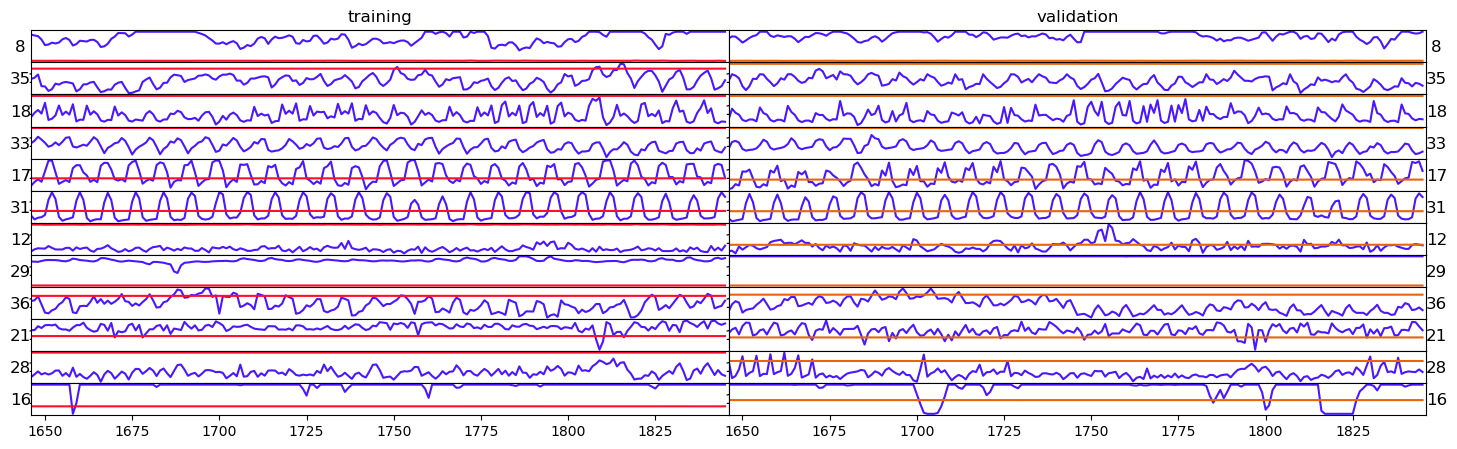

In [12]:
fig, _ = plot_samples_train_val(y_train,outputs,y_val,outputs_val)
fig

In [ ]:
criterion(outputs,y_train)

In [ ]:
criterion(outputs[:100],y_train[:100])

In [ ]:
with torch.no_grad():
    # plt.hist(y_renorm(y_train).sum(dim=1),bins=20,color="b",alpha=0.5)
    plt.hist(y_renorm(outputs).sum(dim=1),bins=20,color="r",alpha=0.5)
    plt.hist(y_renorm(outputs_val).sum(dim=1),bins=20,color="g",alpha=0.5)
    # plt.hist(y_renorm(y_train).sum(dim=1),bins=20,color="b",alpha=0.5)
    
    


In [ ]:
df_output_val.sum(axis=1)